In [ ]:
#data preparation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import math
import graphviz
!apt-get install -qq graphviz
!pip install graphviz
import scipy.cluster.hierarchy as sch

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, classification_report, accuracy_score, confusion_matrix,  precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer

In [ ]:
#get the dataset
autism_screening_adult = fetch_ucirepo(id=426)

#print meta data
print(autism_screening_adult.metadata)

{'uci_id': 426, 'name': 'Autism Screening Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/426/autism+screening+adult', 'data_url': 'https://archive.ics.uci.edu/static/public/426/data.csv', 'abstract': 'Autistic Spectrum Disorder Screening Data for Adult. This dataset is related to classification and predictive tasks.', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': [], 'num_instances': 704, 'num_features': 20, 'feature_types': ['Integer'], 'demographics': ['Age', 'Gender', 'Ethnicity', 'Nationality'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2017, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C5F019', 'creators': ['Fadi Thabtah'], 'intro_paper': None, 'additional_info': {'summary': "See attached variables' description file ", 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_data_splits': None, 'sensitive_data': 

In [ ]:
#assign the features to x and y
autism_df = autism_screening_adult.data.features
y = autism_screening_adult.data.targets

#combine the two into one data frame
autism_df['met_criteria'] = y

print(autism_df['met_criteria'].value_counts())

#see the first 5 obs of features and targets
print(autism_df.head())

met_criteria
NO     515
YES    189
Name: count, dtype: int64
   A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0         1         1         1         1         0         0         1   
1         1         1         0         1         0         0         0   
2         1         1         0         1         1         0         1   
3         1         1         0         1         0         0         1   
4         1         0         0         0         0         0         0   

   A8_Score  A9_Score  A10_Score  ...  gender       ethnicity jaundice  \
0         1         0          0  ...       f  White-European       no   
1         1         0          1  ...       m          Latino       no   
2         1         1          1  ...       m          Latino      yes   
3         1         0          1  ...       f  White-European       no   
4         1         0          0  ...       f             NaN       no   

  family_pdd   country_of_res used_app_befo

In [ ]:
print(autism_df.shape)

(704, 21)


In [ ]:
autism_df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [ ]:
#feature list:
feature_list = list(autism_df.columns)
feature_list

['A1_Score',
 'A2_Score',
 'A3_Score',
 'A4_Score',
 'A5_Score',
 'A6_Score',
 'A7_Score',
 'A8_Score',
 'A9_Score',
 'A10_Score',
 'age',
 'gender',
 'ethnicity',
 'jaundice',
 'family_pdd',
 'country_of_res',
 'used_app_before',
 'result',
 'age_desc',
 'relation',
 'met_criteria']

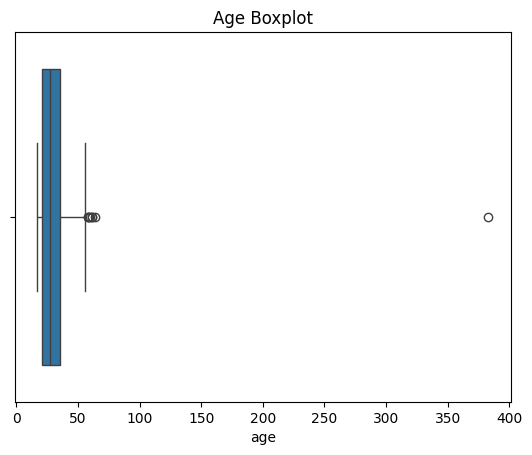

In [ ]:
#Boxplot for age
sns.boxplot(x=autism_df['age'])
plt.title('Age Boxplot')
plt.show()

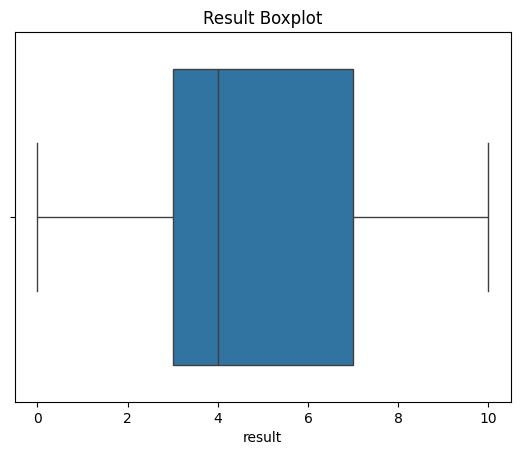

In [ ]:
#Boxplot for result
sns.boxplot(x=autism_df['result'])
plt.title('Result Boxplot')
plt.show()

In [ ]:
#cleaning data, drop missing values & age outliers
autism_df_cleaned = autism_df.dropna()

print(autism_df_cleaned.shape)

autism_df_cleaned = autism_df_cleaned[autism_df_cleaned['age'] <= 124] #oldest person to live was 124 yrs old
print(autism_df_cleaned.shape)

print(autism_df_cleaned['met_criteria'].unique())

#Binarize the met_criteria column
autism_df_cleaned['met_criteria'] = autism_df_cleaned['met_criteria'].map({'YES': 1, 'NO': 0})

#result
print(autism_df_cleaned['met_criteria'].head())

(609, 21)
(608, 21)
['NO' 'YES']
0    0
1    0
2    1
3    0
5    1
Name: met_criteria, dtype: int64


<ipython-input-81-4661f4623818>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autism_df_cleaned['met_criteria'] = autism_df_cleaned['met_criteria'].map({'YES': 1, 'NO': 0})


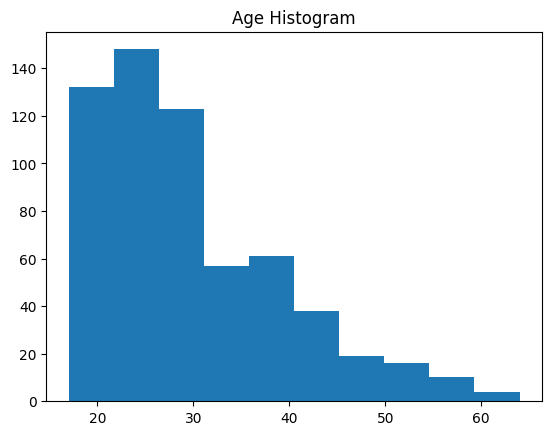

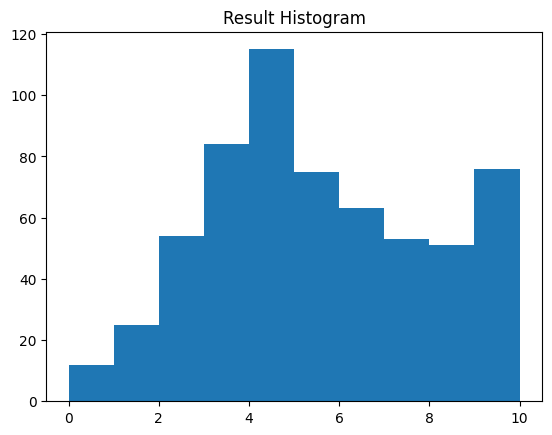

In [ ]:
#Histogram for Age
plt.hist(autism_df_cleaned['age'])
plt.title('Age Histogram')
plt.show()
#Histogram for Result
plt.hist(autism_df_cleaned['result'])
plt.title('Result Histogram')
plt.show()

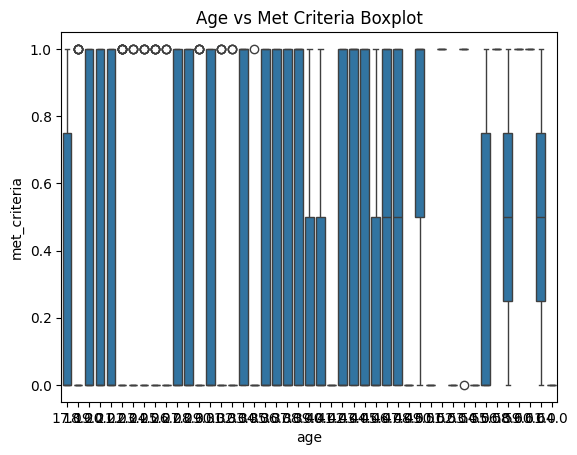

In [ ]:
#Boxplot for age
sns.boxplot(x=autism_df_cleaned['age'], y=autism_df_cleaned['met_criteria'])
plt.title('Age vs Met Criteria Boxplot')
plt.show()

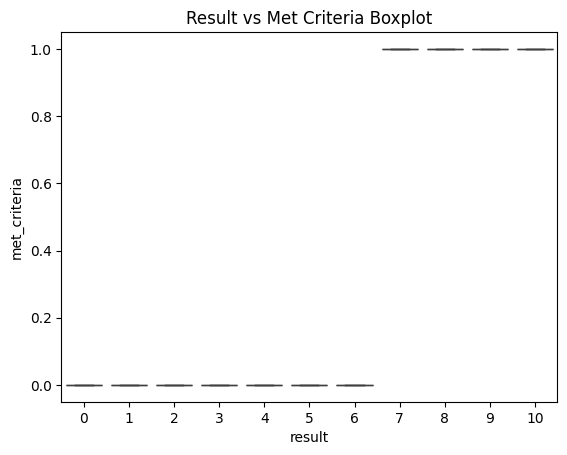

In [ ]:
#Boxplot for result
sns.boxplot(x=autism_df_cleaned['result'], y=autism_df_cleaned['met_criteria'])
plt.title('Result vs Met Criteria Boxplot')
plt.show()

# **Countplots**

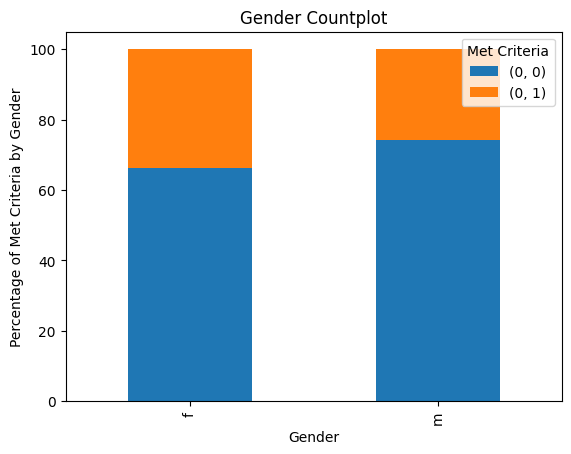

In [ ]:
#percentage stacked plot for gender vs met criteria
df_gender = pd.DataFrame(autism_df_cleaned.groupby(['gender', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent = df_gender.div(df_gender.sum(axis=1), axis=0) * 100

#plot the data
df_percent.plot(kind='bar', stacked=True)

#adding labels and title
plt.xlabel('Gender')
plt.ylabel('Percentage of Met Criteria by Gender')
plt.title('Gender Countplot')
plt.legend(title='Met Criteria', loc='upper right')
plt.show()

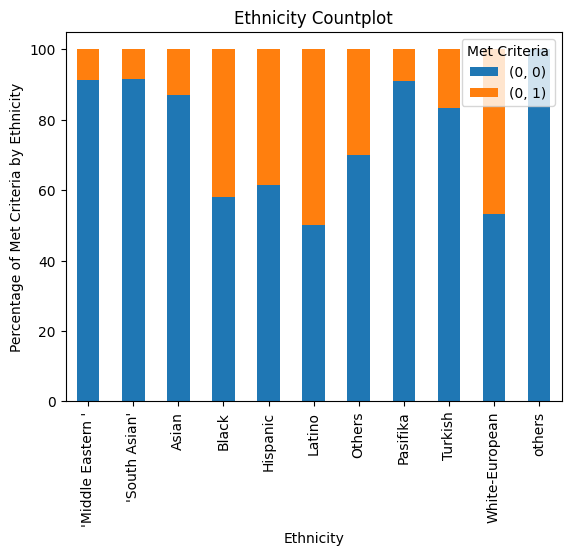

In [ ]:
#countplot for ethnicity vs met criteria
df_ethnic = pd.DataFrame(autism_df_cleaned.groupby(['ethnicity', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_ethnic = df_ethnic.div(df_ethnic.sum(axis=1), axis=0) * 100

#plot the data
df_percent_ethnic.plot(kind='bar', stacked=True)

#sns.displot(autism_df_cleaned, x='ethnicity', hue = 'met_criteria',element = "step", aspect = 2.5)
plt.xlabel('Ethnicity')
plt.ylabel('Percentage of Met Criteria by Ethnicity')
plt.title('Ethnicity Countplot')
plt.legend(title='Met Criteria', loc='upper right')
plt.show()

Text(0.5, 1.0, 'Jaundice Countplot')

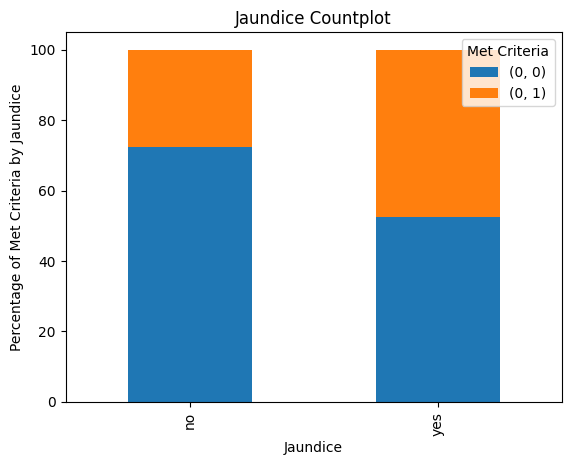

In [ ]:
#countplot for jaundice vs met criteria
df_jaundice = pd.DataFrame(autism_df_cleaned.groupby(['jaundice', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_jaundice = df_jaundice.div(df_jaundice.sum(axis=1), axis=0) * 100

#plot the data
df_percent_jaundice.plot(kind='bar', stacked=True)

#countplot for jaundice vs met criteria
#sns.displot(autism_df_cleaned, x='jaundice', hue = 'met_criteria',element = "step")
plt.xlabel('Jaundice')
plt.ylabel('Percentage of Met Criteria by Jaundice')
plt.legend(title='Met Criteria', loc='upper right')
plt.title('Jaundice Countplot')

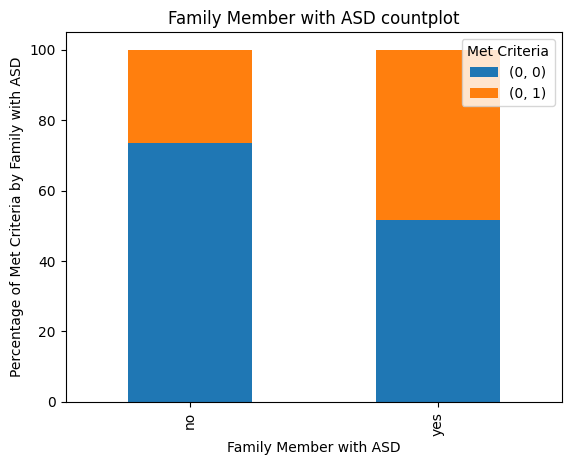

In [ ]:
#countplot for family vs met criteria
df_family = pd.DataFrame(autism_df_cleaned.groupby(['family_pdd', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_family = df_family.div(df_family.sum(axis=1), axis=0) * 100

#plot the data
df_percent_family.plot(kind='bar', stacked=True)

#countplot for family pdd vs met criteria
#sns.displot(autism_df_cleaned, x='family_pdd', hue = 'met_criteria',element = "step")
plt.xlabel('Family Member with ASD')
plt.ylabel('Percentage of Met Criteria by Family with ASD')
plt.title("Family Member with ASD countplot")
plt.legend(title='Met Criteria', loc='upper right')

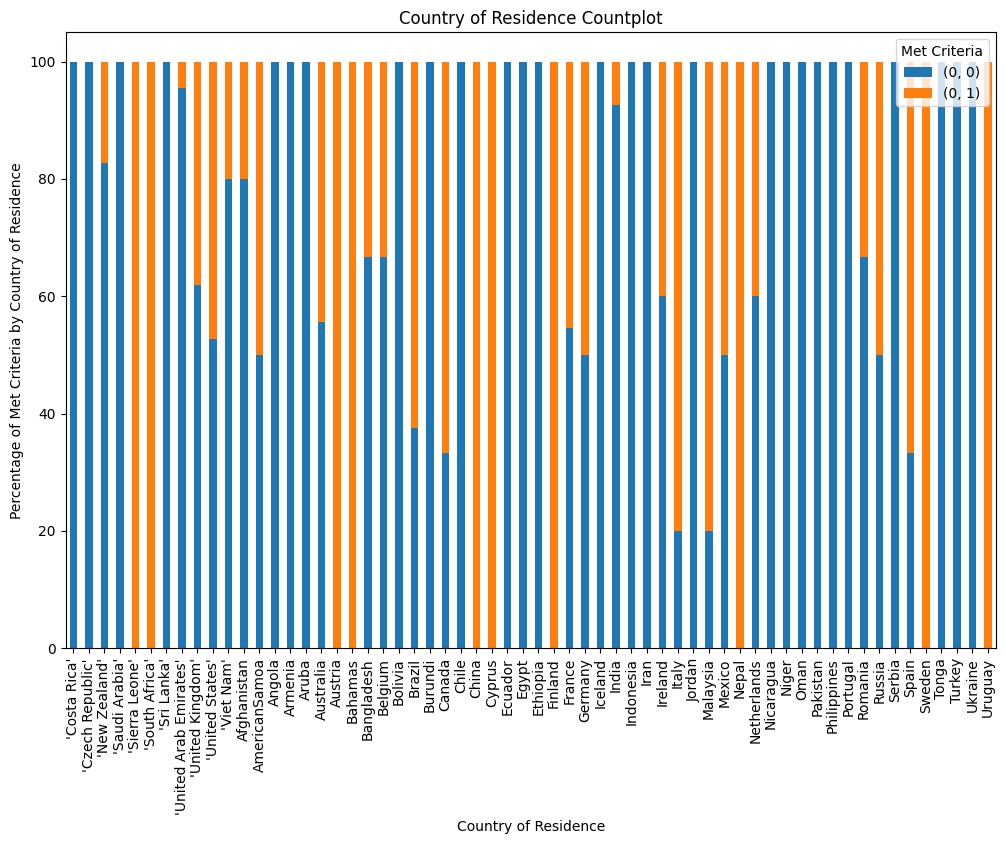

In [ ]:
#countplot for country vs met criteria
df_country = pd.DataFrame(autism_df_cleaned.groupby(['country_of_res', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_country = df_country.div(df_country.sum(axis=1), axis=0) * 100

#plot the data
df_percent_country.plot(kind='bar', stacked=True, figsize=(12, 8))

#countplot for country of residence vs met_criteria
#sns.displot(autism_df_cleaned, x='country_of_res',hue = 'met_criteria',element = "step", aspect = 15)
plt.xlabel('Country of Residence')
plt.ylabel('Percentage of Met Criteria by Country of Residence')
plt.title("Country of Residence Countplot")
plt.legend(title='Met Criteria', loc='upper right')

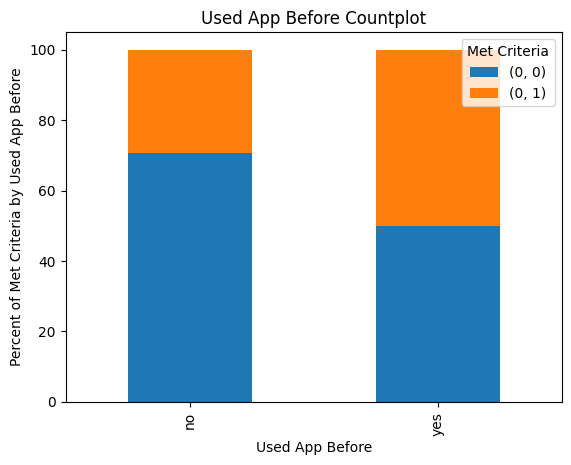

In [ ]:
#countplot for used app before vs met criteria
df_app = pd.DataFrame(autism_df_cleaned.groupby(['used_app_before', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_app = df_app.div(df_app.sum(axis=1), axis=0) * 100

#plot the data
df_percent_app.plot(kind='bar', stacked=True)

#countplot of used app before vs met criteria
#sns.displot(autism_df_cleaned, x='used_app_before', hue = 'met_criteria',element = "step")
plt.xlabel('Used App Before')
plt.ylabel('Percent of Met Criteria by Used App Before')
plt.title("Used App Before Countplot")
plt.legend(title='Met Criteria', loc='upper right')

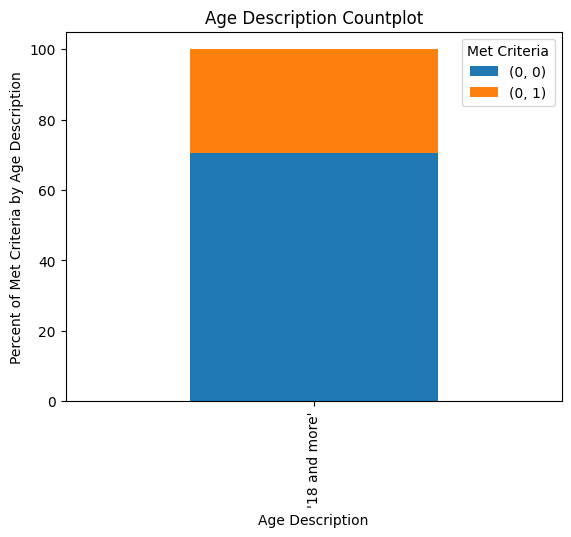

In [ ]:
#countplot for used age before vs met criteria
df_age = pd.DataFrame(autism_df_cleaned.groupby(['age_desc', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_age = df_age.div(df_age.sum(axis=1), axis=0) * 100

#plot the data
df_percent_age.plot(kind='bar', stacked=True)

#countplot for age desc vs met criteria
#sns.displot(autism_df_cleaned, x='age_desc', hue = 'met_criteria',element = "step")
plt.xlabel('Age Description')
plt.ylabel('Percent of Met Criteria by Age Description')
plt.title("Age Description Countplot")
plt.legend(title='Met Criteria', loc='upper right')

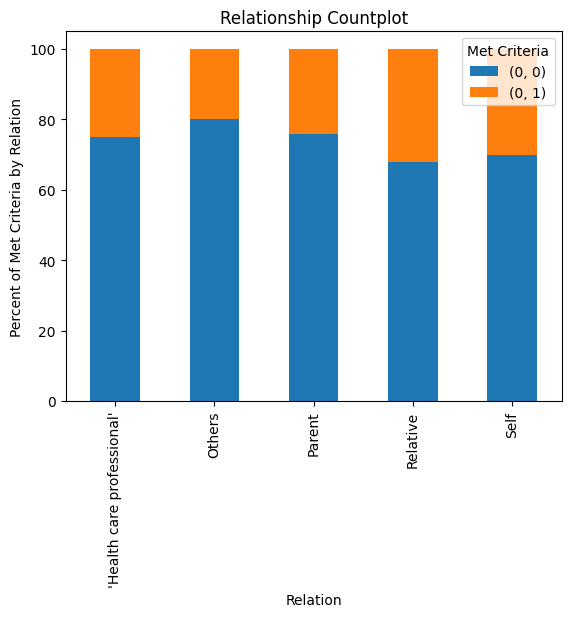

In [ ]:
#countplot for relatione vs met criteria
df_relation = pd.DataFrame(autism_df_cleaned.groupby(['relation', 'met_criteria']).size()).unstack()

#normalize to get the percentages
df_percent_relation = df_relation.div(df_relation.sum(axis=1), axis=0) * 100

#plot the data
df_percent_relation.plot(kind='bar', stacked=True)

#countplot for relation vs met criteria
#sns.displot(autism_df_cleaned, x='relation', hue = 'met_criteria',element = "step", aspect = 2)
plt.xlabel('Relation')
plt.ylabel('Percent of Met Criteria by Relation')
plt.title("Relationship Countplot")
plt.legend(title='Met Criteria', loc='upper right')

'\n#countplot for score vs met criteria\nplt.xlabel(\'A1 Score\')\nplt.ylabel(\'Percent of Met Criteria by A1 Score\')\nplt.title("A1 Score Countplot")\nplt.legend(title=\'Met Criteria\', loc=\'upper right\')'

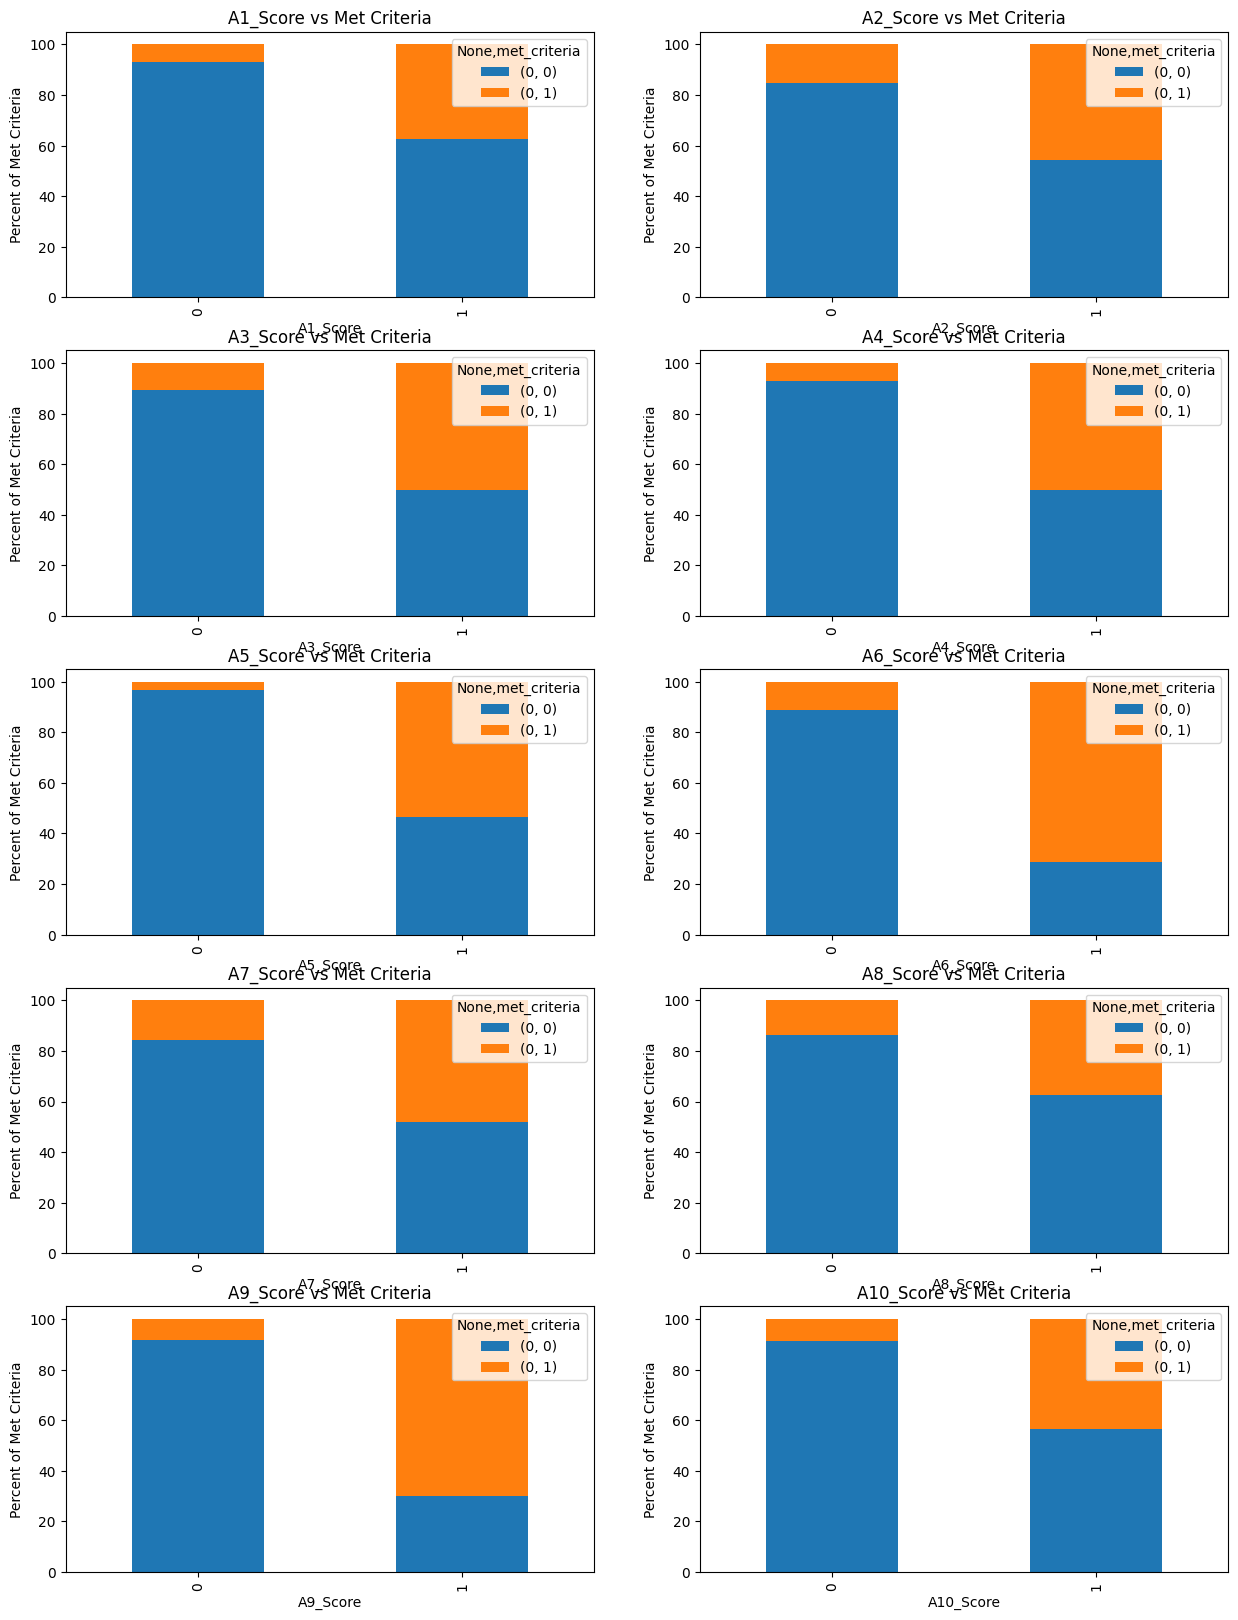

In [ ]:
scores = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score',
          'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']

#countplot for a score vs met criteria
#df_relation = pd.DataFrame(autism_df_cleaned.groupby(['A1_Score', 'met_criteria']).size()).unstack()

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
axes = axes.flatten()#turns 2d array into 1d array

#normalize to get the percentages
#df_percent_relation = df_relation.div(df_relation.sum(axis=1), axis=0) * 100

#plot the data
#df_percent_relation.plot(kind='bar', stacked=True, figsize=(12, 8))

for i, score in enumerate(scores):
    df_score = pd.DataFrame(autism_df_cleaned.groupby([score, 'met_criteria']).size()).unstack()
    df_percent_score = df_score.div(df_score.sum(axis=1), axis=0) * 100
    df_percent_score.plot(kind='bar', stacked=True, ax=axes[i])

    axes[i].set_title(f'{score} vs Met Criteria')
    axes[i].set_xlabel(score)
    axes[i].set_ylabel('Percent of Met Criteria')
'''
#countplot for score vs met criteria
plt.xlabel('A1 Score')
plt.ylabel('Percent of Met Criteria by A1 Score')
plt.title("A1 Score Countplot")
plt.legend(title='Met Criteria', loc='upper right')'''

In [ ]:
#mean of met_criteria by relationship & gender
df_gender_mean = autism_df_cleaned.groupby('gender')['met_criteria'].mean().reset_index()

#result
print("Mean of met_criteria by Gender")
print(df_gender_mean)

df_relation_mean = autism_df_cleaned.groupby('relation')['met_criteria'].mean().reset_index()
print("\nMean of met_criteria by Relationship")
print(df_relation_mean)


Mean of met_criteria by Gender
  gender  met_criteria
0      f      0.337979
1      m      0.258567

Mean of met_criteria by Relationship
                     relation  met_criteria
0  'Health care professional'      0.250000
1                      Others      0.200000
2                      Parent      0.240000
3                    Relative      0.321429
4                        Self      0.301344


In [ ]:
#drop columns that aren't useful and binarize the columns
df_autism = autism_df_cleaned.drop(['age_desc', 'country_of_res', 'result'], axis=1)

#see what columns need to be binarized
print(df_autism.dtypes)
print(df_autism['met_criteria'].value_counts())

A1_Score             int64
A2_Score             int64
A3_Score             int64
A4_Score             int64
A5_Score             int64
A6_Score             int64
A7_Score             int64
A8_Score             int64
A9_Score             int64
A10_Score            int64
age                float64
gender              object
ethnicity           object
jaundice            object
family_pdd          object
used_app_before     object
relation            object
met_criteria         int64
dtype: object
met_criteria
0    428
1    180
Name: count, dtype: int64


# **Logistic Regression**

In [ ]:
#get all columns that aren't float to one hot encode them
X = df_autism.loc[:, df_autism.columns != 'met_criteria']
y = df_autism['met_criteria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234)

numeric_features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age']
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']

#numeric features pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#create a pipeline that combines the preprocessor with the estimator
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#create a logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


#fit model to the training data
model.fit(X_train, y_train)

#make prediction on the test data
probability_predictions = model.predict_proba(X_test)

#compute log loss
l_loss = log_loss(y_test, probability_predictions)
print("\nLog Loss: " + str(l_loss))

#make predictions on the test data
y_pred = model.predict(X_test)

#print first 5 class label predictions
print("First 5 Class labels: " + str(y_pred[0:5]))

#compute accuarcy score on class_label_predictions
acc_score = accuracy_score(y_test, y_pred)
print('Accuracy: ' + str(acc_score))

#print(classification_report(y_test, y_pred))

#make confusion matrix
c_m = confusion_matrix(y_test, y_pred, labels=[1, 0])
pd.DataFrame(c_m, columns=['predicted: met_criteria', 'predicted: did not met_criteria'],
             index=['actual: met_criteria', 'actual: did not met_criteria'])



Log Loss: 0.05738399968776485
First 5 Class labels: [0 0 1 0 0]
Accuracy: 0.9890710382513661


,predicted: met_criteria,predicted: did not met_criteria
actual: met_criteria,50,1
actual: did not met_criteria,1,131


# **Feature Importance**

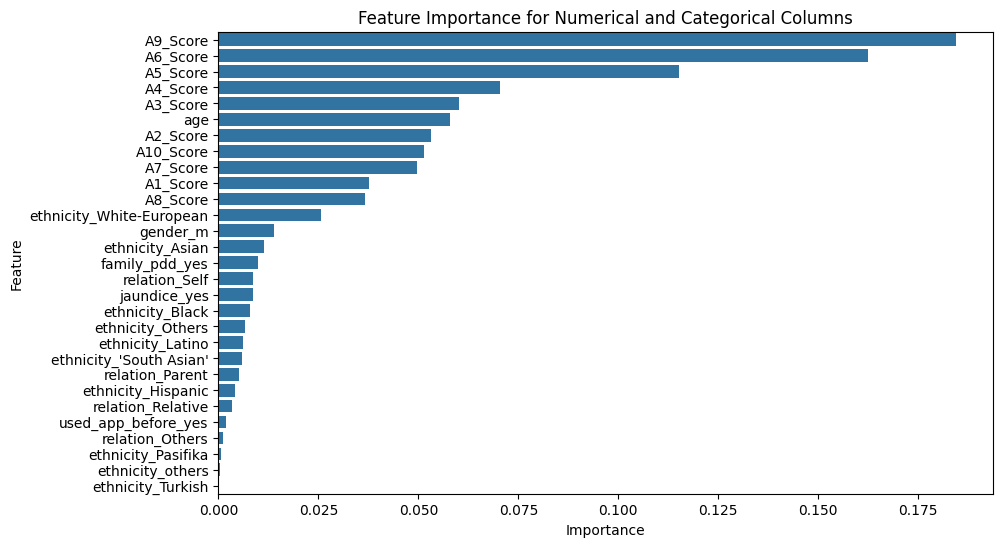

In [ ]:
#feature importance
y = df_autism['met_criteria']
X = df_autism.drop('met_criteria', axis=1)

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = 'passthrough'

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(drop='first')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
rf = RandomForestClassifier()

# Create and evaluate the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

# Fit the pipeline
clf.fit(X, y)

# Get feature importances
importances = clf.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
feature_names = numerical_cols.tolist() + clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

# Convert to DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Numerical and Categorical Columns')
plt.show()

# **New Logistic Regression**

In [ ]:
#All variables that were under Age will get dropped
#get all columns that aren't float to one hot encode them
#dropped irrevelant scores fromd df
df = df_autism.drop(['A1_Score', 'A2_Score', 'A3_Score', 'A7_Score', 'A8_Score', 'A10_Score'], axis=1)

X = df.loc[:, df.columns != 'met_criteria']
y = df['met_criteria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234)

numeric_features = ['A4_Score', 'A5_Score', 'A6_Score', 'A9_Score', 'age']
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']

#numeric features pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

#categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#create a pipeline that combines the preprocessor with the estimator
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#create a logistic regression model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

#fit model to the training data
model.fit(X_train, y_train)

#make prediction on the test data
probability_predictions = model.predict_proba(X_test)

#compute log loss
l_loss = log_loss(y_test, probability_predictions)
print("\nLog Loss: " + str(l_loss))

#make predictions on the test data
y_pred = model.predict(X_test)

#compute accuarcy score on class_label_predictions
acc_score = accuracy_score(y_test, y_pred)

print('Test Accuracy: ' + str(acc_score))

#print(classification_report(y_test, y_pred))

#make confusion matrix
c_m = confusion_matrix(y_test, y_pred, labels=[1, 0])
pd.DataFrame(c_m, columns=['predicted: met_criteria', 'predicted: did not met_criteria'],
              index=['actual: met_criteria', 'actual: did not met_criteria'])



Log Loss: 0.27498735107910266
Test Accuracy: 0.8852459016393442


,predicted: met_criteria,predicted: did not met_criteria
actual: met_criteria,40,11
actual: did not met_criteria,10,122


## **Regularization**

Ridge Model:
Accuracy: 0.8743169398907104
Precision: 0.7592592592592593
Recall: 0.803921568627451
F1-score: 0.780952380952381
AUC: 0.9485294117647058

Lasso Model:
Accuracy: 0.8743169398907104
Precision: 0.7592592592592593
Recall: 0.803921568627451
F1-score: 0.780952380952381
AUC: 0.9480837789661319


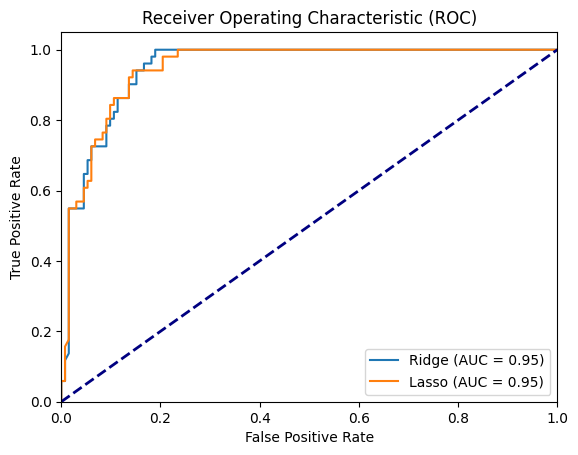

In [ ]:
X = df.loc[:, df.columns != 'met_criteria']
y = df['met_criteria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234)

numeric_features = ['A4_Score', 'A5_Score', 'A6_Score', 'A9_Score', 'age']
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']

# Preprocessing for numerical data
numeric_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(drop='first')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model with L2 regularization (Ridge)
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000))
])

# Model with L1 regularization (Lasso)
model_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

# Fit the models
model_ridge.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)

# Make predictions for Ridge model
y_pred_ridge = model_ridge.predict(X_test)
y_proba_ridge = model_ridge.predict_proba(X_test)[:, 1]  # Probability of positive class

# Make predictions for Lasso model
y_pred_lasso = model_lasso.predict(X_test)
y_proba_lasso = model_lasso.predict_proba(X_test)[:, 1]

# Calculate ROC curves and AUC
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_proba_ridge)
auc_ridge = auc(fpr_ridge, tpr_ridge)

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_proba_lasso)
auc_lasso = auc(fpr_lasso, tpr_lasso)

# Calculate metrics for Ridge model
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
precision_ridge = precision_score(y_test, y_pred_ridge)
recall_ridge = recall_score(y_test, y_pred_ridge)
f1_ridge = f1_score(y_test, y_pred_ridge)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_proba_ridge)
auc_ridge = auc(fpr_ridge, tpr_ridge)

# Calculate metrics for Lasso model
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
precision_lasso = precision_score(y_test, y_pred_lasso)
recall_lasso = recall_score(y_test, y_pred_lasso)
f1_lasso = f1_score(y_test, y_pred_lasso)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_proba_lasso)
auc_lasso = auc(fpr_lasso, tpr_lasso)

print("Ridge Model:")
print("Accuracy:", accuracy_ridge)
print("Precision:", precision_ridge)
print("Recall:", recall_ridge)
print("F1-score:", f1_ridge)
print("AUC:", auc_ridge)

print("\nLasso Model:")
print("Accuracy:", accuracy_lasso)
print("Precision:", precision_lasso)
print("Recall:", recall_lasso)
print("F1-score:", f1_lasso)
print("AUC:", auc_lasso)

plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC = {auc_ridge:.2f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'Lasso (AUC = {auc_lasso:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

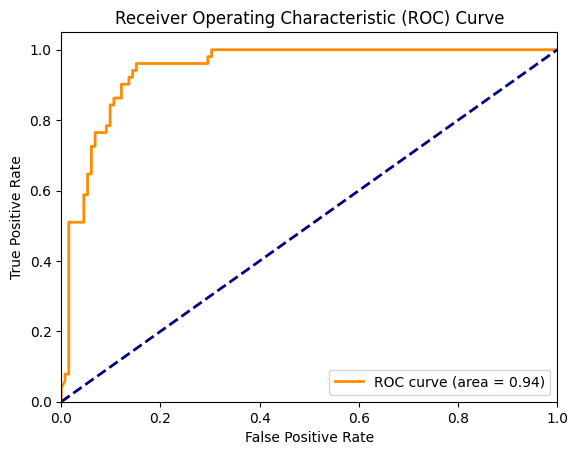

ROC AUC score:  0.9445187165775402
Accuracy:  0.8743169398907104


In [ ]:
X = df.loc[:, df.columns != 'met_criteria']
y = df['met_criteria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1234)

numeric_features = ['A4_Score', 'A5_Score', 'A6_Score', 'A9_Score', 'age']
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']

# Numeric features pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create elastic net model
model_elastic_net = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000))
])

# Define parameter grid
param_grid = {
    'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10]
}

# Create grid search object
grid_search = GridSearchCV(model_elastic_net, param_grid, cv=5)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make probability predictions on the test data
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC_AUC score
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC score: ", roc_auc)

#print accuracy
print("Accuracy: ", accuracy_score(y_test, best_model.predict(X_test)))

# **Tree Analysis**

Random Forrest Classification

In [ ]:
X = df.loc[:, df.columns != 'met_criteria']
y = df['met_criteria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

numeric_features = ['A4_Score', 'A5_Score', 'A6_Score', 'A9_Score', 'age']
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']

# Numeric features pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical features pipeline
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor that combines the numeric and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Random Forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=1234))
])

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract the first tree from the forest
estimator = model.named_steps['classifier'].estimators_[0]

# Get feature names
feature_names = numeric_features + list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features))

# Export the tree as a dot file
dot_data = export_graphviz(estimator, out_file=None,
                           feature_names=feature_names,
                           class_names=['did not meet criteria', 'met criteria'],
                           filled=True, rounded=True,
                           special_characters=True)

# Visualize the tree
graph = graphviz.Source(dot_data)
graph.render("random_forest_tree")
graph

# Make prediction on the test data
probability_predictions = model.predict_proba(X_test)

# Compute log loss
l_loss = log_loss(y_test, probability_predictions)
print("\nLog Loss: " + str(l_loss))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Compute accuracy score on class_label_predictions
acc_score = accuracy_score(y_test, y_pred)
print('Test Accuracy: ' + str(acc_score))
# compute AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC: ", auc)

# Print classification report
print(classification_report(y_test, y_pred))

# Make confusion matrix
c_m = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(pd.DataFrame(c_m, columns=['predicted: met_criteria', 'predicted: did not met_criteria'],
                   index=['actual: met_criteria', 'actual: did not met_criteria']))


Log Loss: 0.4963165989418423
Test Accuracy: 0.8633879781420765
AUC:  0.8150623885918004
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       132
           1       0.78      0.71      0.74        51

    accuracy                           0.86       183
   macro avg       0.84      0.82      0.82       183
weighted avg       0.86      0.86      0.86       183

                              predicted: met_criteria  \
actual: met_criteria                               36   
actual: did not met_criteria                       10   

                              predicted: did not met_criteria  
actual: met_criteria                                       15  
actual: did not met_criteria                              122  


# **PCA**

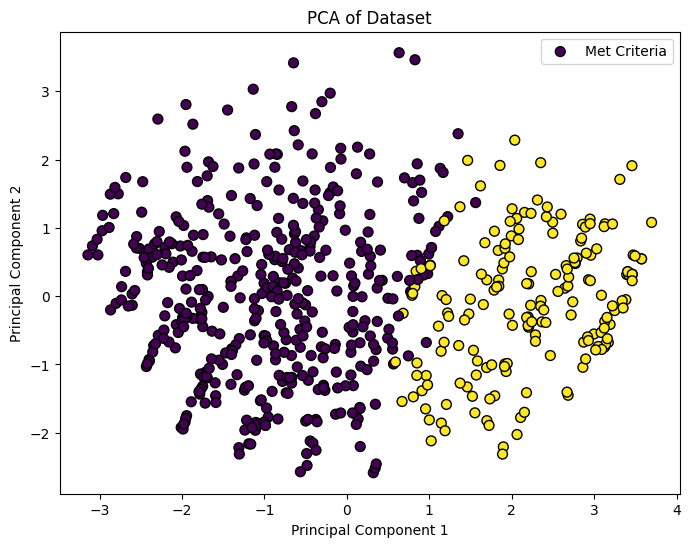

In [ ]:
categorical_features = ['gender', 'ethnicity', 'jaundice', 'family_pdd', 'used_app_before']
numeric_features = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age']

X = df_autism.loc[:, df_autism.columns != 'met_criteria']
y = df_autism['met_criteria']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Assuming X is your feature set
X_preprocessed = preprocessor.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_preprocessed)

# Scatter plot of PCA results
plt.figure(figsize=(8, 6))
#plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50, label='Met Criteria')
plt.legend()
plt.show()

add in clustering